In [ ]:
!pip install -q jina git+https://github.com/jina-ai/jina-commons
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [24]:
!mkdir /content/x && git clone https://github.com/pmernyei/wiki-cs-dataset /content/x

/content


In [37]:
import json
from itertools import chain

import torch
from torch_geometric.data import InMemoryDataset, Data, download_url
from torch_geometric.datasets import wikics

import pandas as pd
import json

### Data loading

In [39]:
dataset = wikics.WikiCS('./wiki-cs-dataset_autodownload')
dataset.data

Data(edge_index=[2, 297110], stopping_mask=[11701, 20], test_mask=[11701], train_mask=[11701, 20], val_mask=[11701, 20], x=[11701, 300], y=[11701])

### Data exploration

In [40]:
dataset.num_classes

10

In [41]:
# the 300 dimension corresponds to glove embebeddings
# for each word in the document averaged over
dataset.data.x.shape

torch.Size([11701, 300])

In [42]:
metadata = json.load(open('/content/x/dataset/metadata.json'))
metadata.keys()

dict_keys(['labels', 'nodes'])

In [43]:
metadata['labels']

{'0': 'Computational linguistics',
 '1': 'Databases',
 '2': 'Operating systems',
 '3': 'Computer architecture',
 '4': 'Computer security',
 '5': 'Internet protocols',
 '6': 'Computer file systems',
 '7': 'Distributed computing architecture',
 '8': 'Web technology',
 '9': 'Programming language topics'}

In [44]:
len(metadata['nodes'])

11701

For each node we have the following information

In [45]:
metadata['nodes'][40].keys()

dict_keys(['id', 'title', 'label', 'outlinks', 'tokens'])

Note that from a node `title` we can construct a valid URL from wikipedia as follows:

In [46]:
def create_url(title):
    return f'https://en.wikipedia.org/wiki/{title}'

In [47]:
pos = 1900
create_url(metadata['nodes'][pos]['title'])

'https://en.wikipedia.org/wiki/Alexandre_Julliard'

### Defining a GCN

In [49]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features=300, num_classes=10, hidden_channels=128):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def encode(self, x, edge_index):
        feature_map = None

        def get_activation(model, model_inputs, output):
            nonlocal feature_map
            feature_map = output.detach()

        handle = self.conv1.register_forward_hook(get_activation)
        self.forward(x, edge_index)
        handle.remove()
        return feature_map

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [50]:
num_classes = len(dataset.data.y.unique())
num_features = dataset.data.x.shape[1]

model = GCN(num_node_features=num_features, 
            num_classes=num_classes,
            hidden_channels=128)

In [51]:
model

GCN(
  (conv1): GCNConv(300, 128)
  (conv2): GCNConv(128, 10)
)

### Training a GCN

In [52]:
data = dataset.data 
loss_values = []

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(model, data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      #mask = data.train_mask[:,0]
      #loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
      loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.  
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(model, data):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

n_epochs = 400

for epoch in range(1, n_epochs):
    loss = train(model, data)
    loss_values.append(loss)
    print(f'\rEpoch: {epoch:03d}, Loss: {loss:.4f}', end='')

Epoch: 399, Loss: 0.5658

In [54]:
test_acc = test(model, data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8468


### Storing model to disk

In [56]:
torch.save(model.state_dict(), './saved_model.torch')

### Load model from disk

In [57]:
model2 = GCN(num_node_features= num_features, 
             num_classes= num_classes,
             hidden_channels=128)

model2.load_state_dict(torch.load('./saved_model.torch'))

<All keys matched successfully>

In [58]:
test(model2, data)

0.8467590217205404

### Visualized learned embeddings

In [59]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

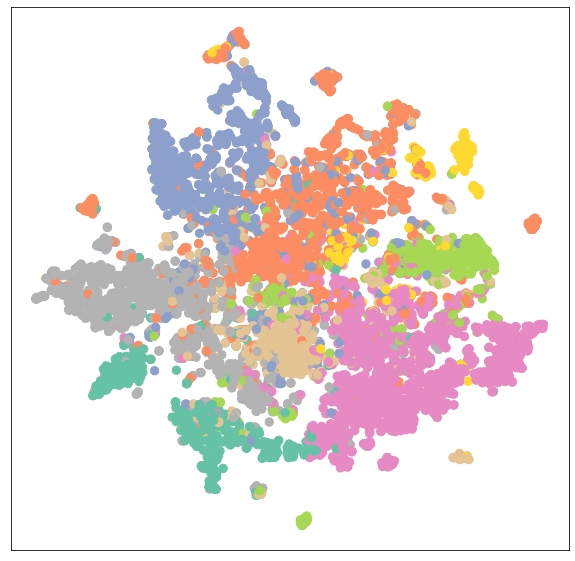

In [60]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)